In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


import torch.nn as nn
import torch.optim as optim

import numpy as np

## Import the movieLens dataset



In [8]:

movies_path = "ml-1m/movies.dat"
ratings_path = "ml-1m/ratings.dat"
users_path = "ml-1m/users.dat"

# Leer el archivo de movies
movies = pd.read_csv(movies_path, sep='::', header=None, encoding="latin-1")
movies.columns = ['MovieID', 'Title', 'Genres']

# Leer el archivo de users
users = pd.read_csv(users_path, sep='::', header=None, encoding="latin-1")
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

# Leer el archivo de ratings
ratings = pd.read_csv(ratings_path, sep='::', header=None, encoding="latin-1")
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

# Mostrar los primeros registros de cada archivo
print("\nMovies:")
print(movies.head())

print("\nUsers:")
print(users.head())

print("\nRatings:")
print(ratings.head())


/tmp/ipykernel_9941/886222605.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv(movies_path, sep='::', header=None, encoding="latin-1")
/tmp/ipykernel_9941/886222605.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv(users_path, sep='::', header=None, encoding="latin-1")
/tmp/ipykernel_9941/886222605.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.re


Movies:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

Users:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

Ratings:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


/tmp/ipykernel_9941/3981066417.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


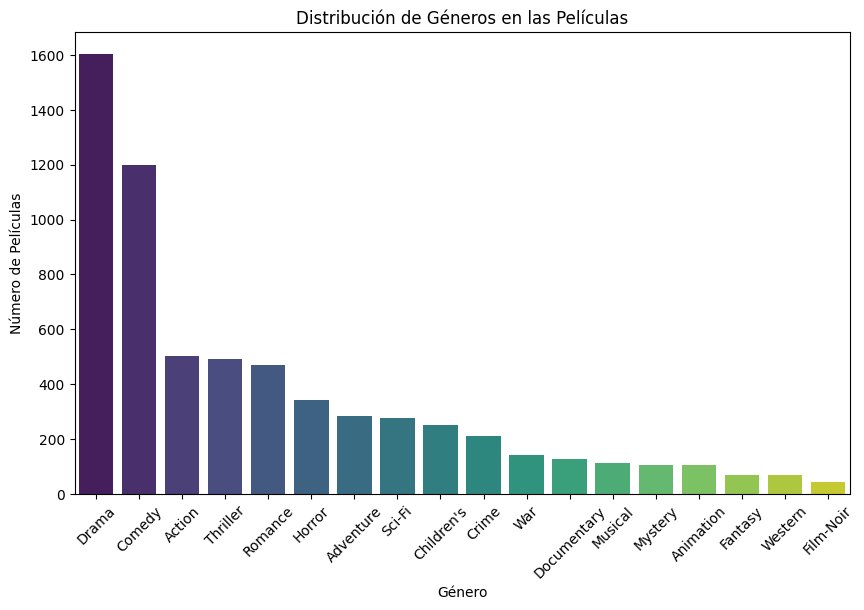

/tmp/ipykernel_9941/3981066417.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='coolwarm')


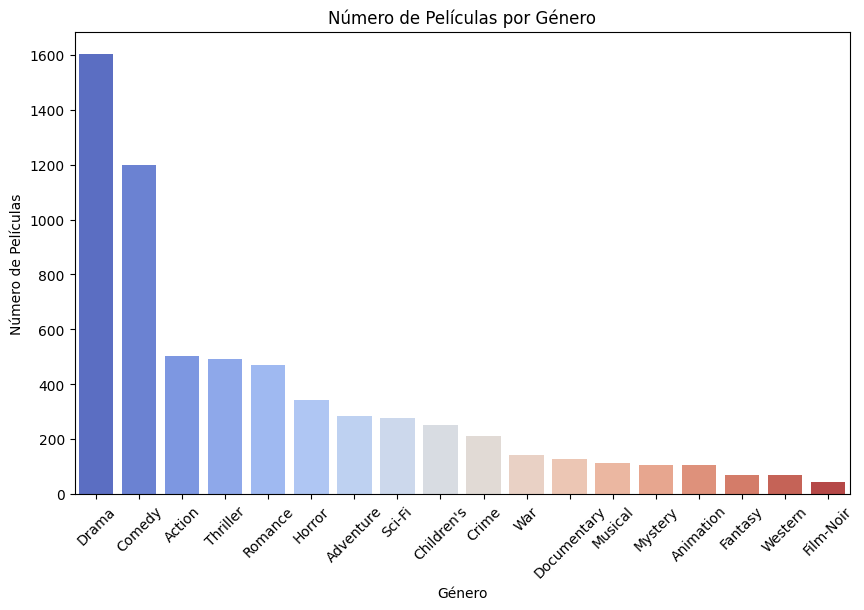

/tmp/ipykernel_9941/3981066417.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_visualizations.index, y=genre_visualizations.values, palette='magma')


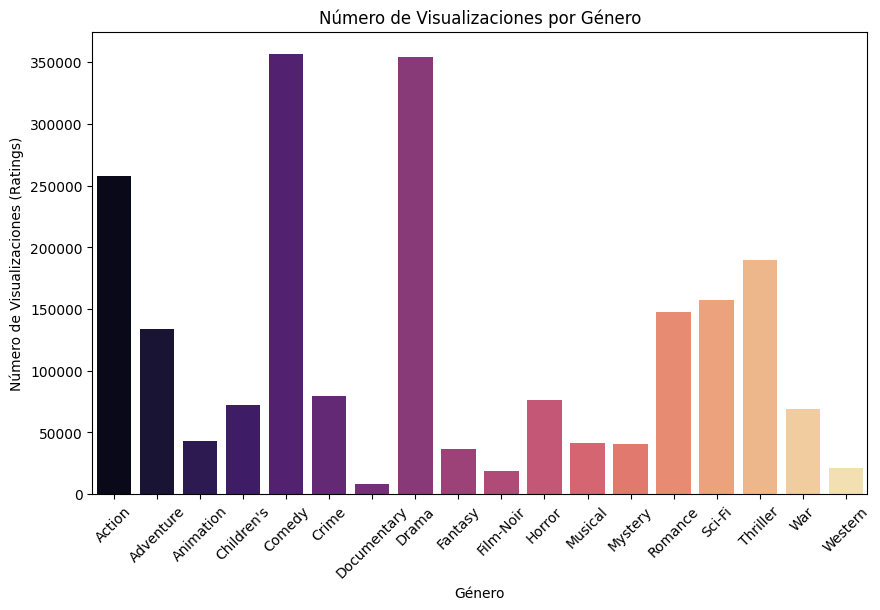

/tmp/ipykernel_9941/3981066417.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_avg_ratings.index, y=genre_avg_ratings.values, palette='coolwarm')


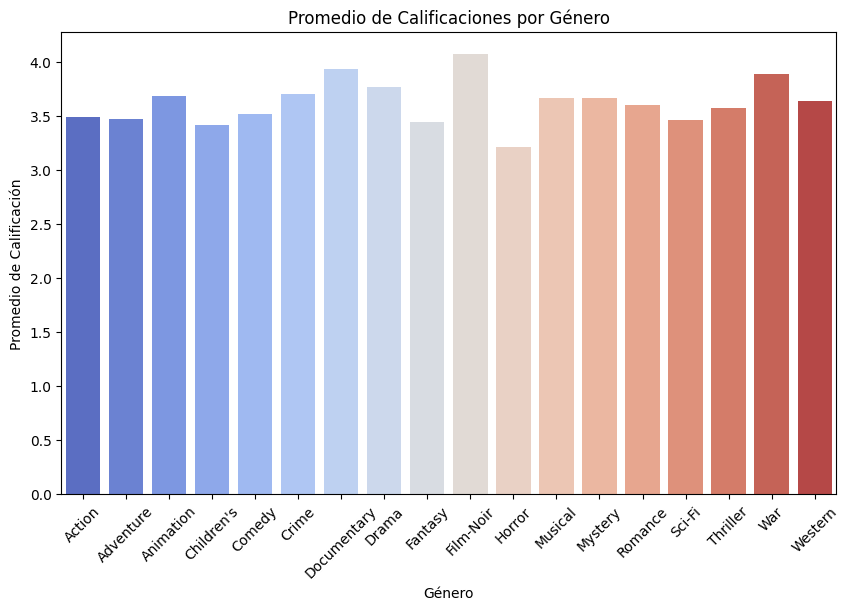

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarnos de que los gráficos sean visualizados correctamente en Jupyter Notebook
%matplotlib inline

# 1. Distribución de géneros
# Dividir los géneros y contar cuántas veces aparece cada uno
genres_split = movies['Genres'].str.split('|', expand=True).stack()
genre_counts = genres_split.value_counts()

# Gráfico de distribución de géneros
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Distribución de Géneros en las Películas')
plt.xlabel('Género')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45)
plt.show()

# 2. Número de películas con cada género
# Mostrar el número de películas por cada género
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='coolwarm')
plt.title('Número de Películas por Género')
plt.xlabel('Género')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45)
plt.show()

# 3. Número de visualizaciones por género
# Primero, vamos a obtener el número de ratings por género
# Crear una columna 'Genre' en el DataFrame de ratings para vincular las películas con los géneros
ratings_with_genre = ratings.merge(movies[['MovieID', 'Genres']], on='MovieID', how='left')

# Dividir los géneros en una lista para cada rating
ratings_with_genre['Genres'] = ratings_with_genre['Genres'].str.split('|')

# Expandir los géneros en varias filas
ratings_expanded = ratings_with_genre.explode('Genres')

# Contar las visualizaciones por género
genre_visualizations = ratings_expanded.groupby('Genres')['Rating'].count()

# Gráfico de número de visualizaciones por género
plt.figure(figsize=(10,6))
sns.barplot(x=genre_visualizations.index, y=genre_visualizations.values, palette='magma')
plt.title('Número de Visualizaciones por Género')
plt.xlabel('Género')
plt.ylabel('Número de Visualizaciones (Ratings)')
plt.xticks(rotation=45)
plt.show()

# 4. Promedio de calificaciones por género
# Promedio de rating por cada género
genre_avg_ratings = ratings_expanded.groupby('Genres')['Rating'].mean()

# Gráfico de promedio de calificaciones por género
plt.figure(figsize=(10,6))
sns.barplot(x=genre_avg_ratings.index, y=genre_avg_ratings.values, palette='coolwarm')
plt.title('Promedio de Calificaciones por Género')
plt.xlabel('Género')
plt.ylabel('Promedio de Calificación')
plt.xticks(rotation=45)
plt.show()


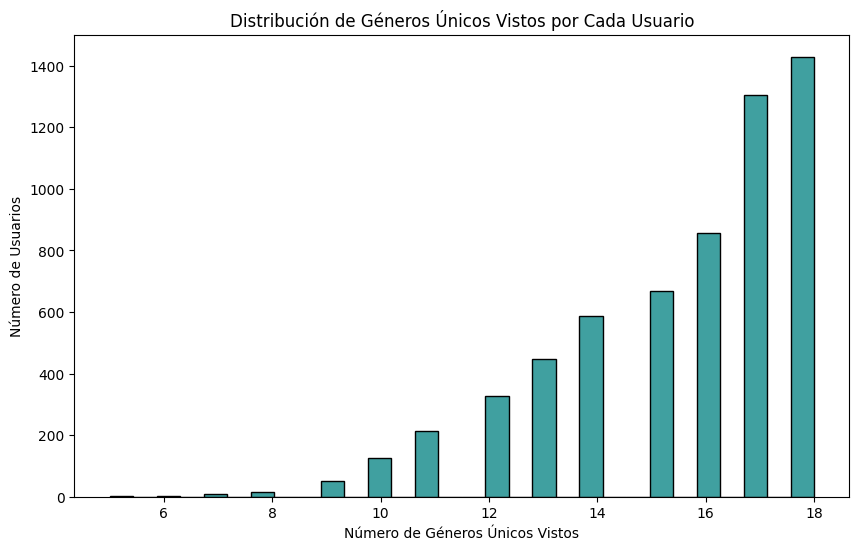

In [12]:
# 1. Asociar los géneros a cada rating
ratings_with_genre = ratings.merge(movies[['MovieID', 'Genres']], on='MovieID', how='left')

# 2. Dividir los géneros en una lista por cada rating
ratings_with_genre['Genres'] = ratings_with_genre['Genres'].str.split('|')

# 3. Expandir los géneros en varias filas
ratings_expanded = ratings_with_genre.explode('Genres')

# 4. Contar cuántos géneros únicos ha visto cada usuario
user_genres = ratings_expanded.groupby('UserID')['Genres'].nunique()

# 5. Graficar la distribución del número de géneros únicos vistos por cada usuario
plt.figure(figsize=(10,6))
sns.histplot(user_genres, kde=False, color='teal', bins=30)
plt.title('Distribución de Géneros Únicos Vistos por Cada Usuario')
plt.xlabel('Número de Géneros Únicos Vistos')
plt.ylabel('Número de Usuarios')
plt.show()


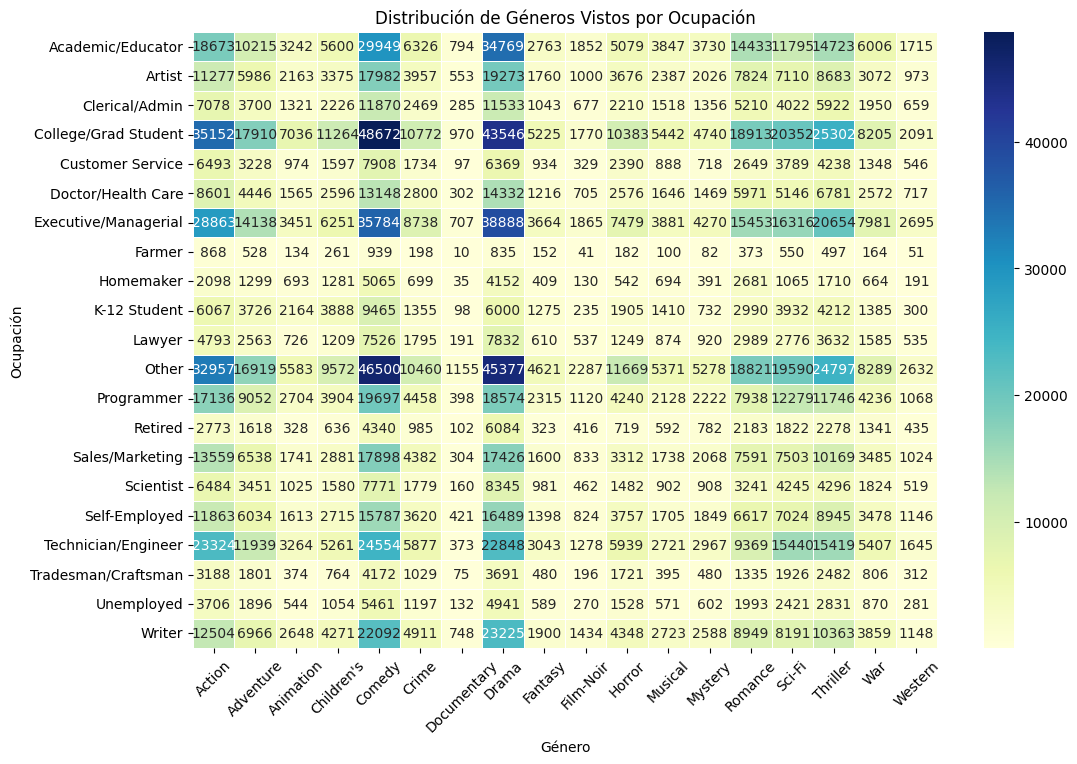

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mapa de ocupaciones (número -> nombre de ocupación)
occupation_map = {
    0: "Other",
    1: "Academic/Educator",
    2: "Artist",
    3: "Clerical/Admin",
    4: "College/Grad Student",
    5: "Customer Service",
    6: "Doctor/Health Care",
    7: "Executive/Managerial",
    8: "Farmer",
    9: "Homemaker",
    10: "K-12 Student",
    11: "Lawyer",
    12: "Programmer",
    13: "Retired",
    14: "Sales/Marketing",
    15: "Scientist",
    16: "Self-Employed",
    17: "Technician/Engineer",
    18: "Tradesman/Craftsman",
    19: "Unemployed",
    20: "Writer"
}



# 1. Asociar los géneros a cada rating
ratings_with_genre = ratings.merge(movies[['MovieID', 'Genres']], on='MovieID', how='left')

# 2. Dividir los géneros en una lista para cada rating
ratings_with_genre['Genres'] = ratings_with_genre['Genres'].str.split('|')

# 3. Expandir los géneros en varias filas
ratings_expanded = ratings_with_genre.explode('Genres')

# 4. Unir con el DataFrame de usuarios para obtener la ocupación
ratings_expanded_with_occupation = ratings_expanded.merge(users[['UserID', 'Occupation']], on='UserID', how='left')
# 5. Reemplazar los números de ocupación por los nombres de ocupación
ratings_expanded_with_occupation['Occupation'] = ratings_expanded_with_occupation['Occupation'].map(occupation_map)


# 5. Contar el número de visualizaciones por ocupación y género
occupation_genre_counts = ratings_expanded_with_occupation.groupby(['Occupation', 'Genres']).size().unstack(fill_value=0)

# 6. Crear el heatmap
plt.figure(figsize=(12,8))
sns.heatmap(occupation_genre_counts, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
plt.title('Distribución de Géneros Vistos por Ocupación')
plt.xlabel('Género')
plt.ylabel('Ocupación')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


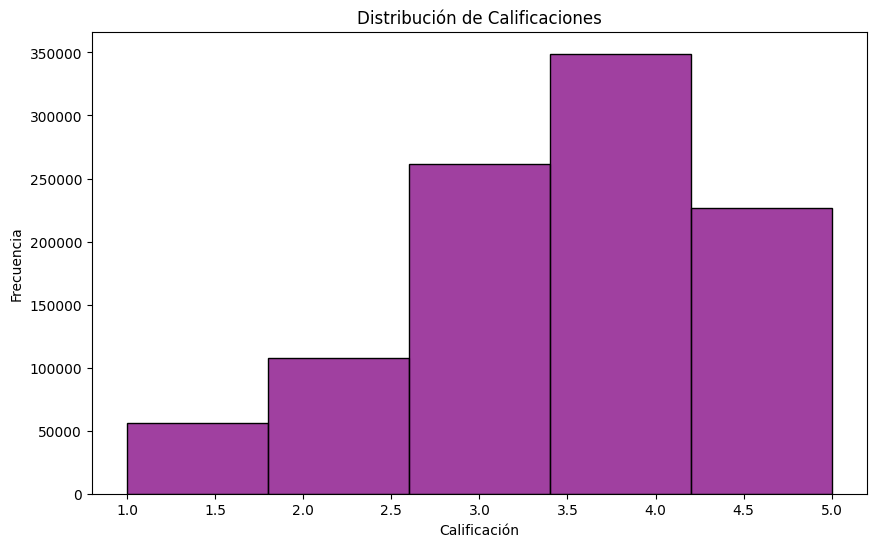

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(ratings['Rating'], kde=False, bins=5, color='purple')
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()


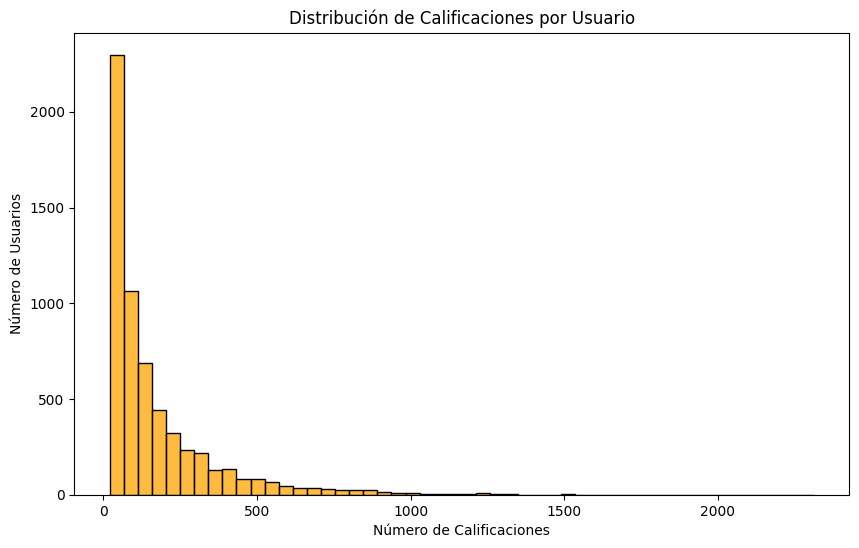

In [18]:
user_ratings_count = ratings.groupby('UserID').size()
plt.figure(figsize=(10,6))
sns.histplot(user_ratings_count, kde=False, color='orange', bins=50)
plt.title('Distribución de Calificaciones por Usuario')
plt.xlabel('Número de Calificaciones')
plt.ylabel('Número de Usuarios')
plt.show()


/tmp/ipykernel_9941/4025217394.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_movie_titles, y=avg_movie_ratings.values, palette='viridis')


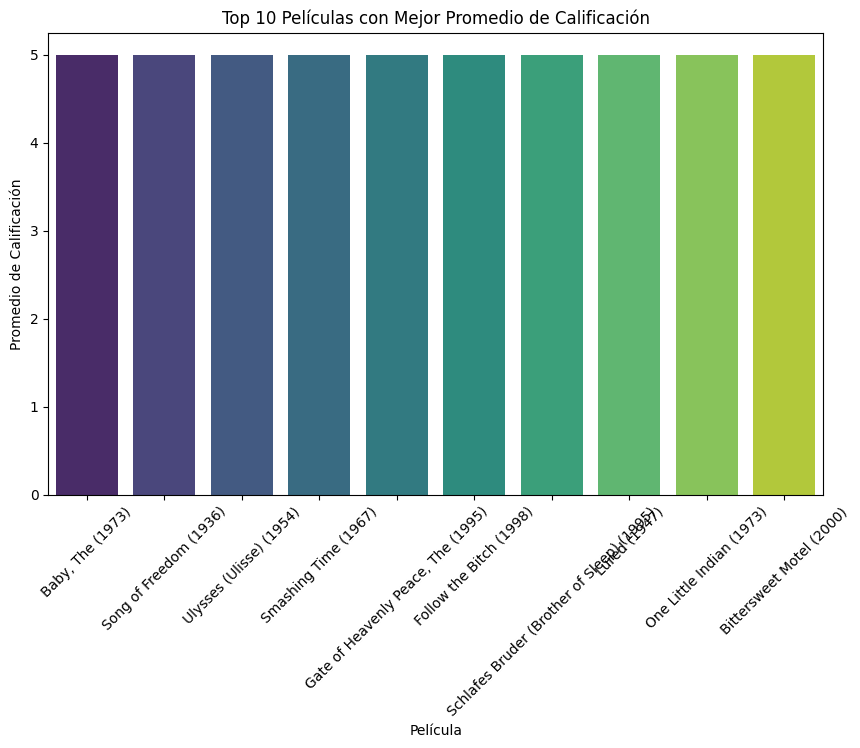

In [19]:
avg_movie_ratings = ratings.groupby('MovieID')['Rating'].mean().sort_values(ascending=False).head(10)
avg_movie_titles = movies.set_index('MovieID').loc[avg_movie_ratings.index, 'Title']
plt.figure(figsize=(10,6))
sns.barplot(x=avg_movie_titles, y=avg_movie_ratings.values, palette='viridis')
plt.title('Top 10 Películas con Mejor Promedio de Calificación')
plt.xlabel('Película')
plt.ylabel('Promedio de Calificación')
plt.xticks(rotation=45)
plt.show()


NameError: name 'movies' is not defined